<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 10 - Deep Learning Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Keras Deep Learning Classifier](#keras-dl)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Deep Learning with Keras Introduction <a class="anchor" id="introduction"></a>

Deep learning is a term used to cover a wide range of models that have grown out of the miltilayer perceptron framework. With applications in computer vision, natural language processing, autonomous driving, synthetic data generation, and much more, there are new deep learning neural network architectures being introduced all the time.

For the purposes of analyzing the poverty dataset, many of the advanced techniques of deep learning mentioned above are inapplicable. So this is by no means a general introduction to deep learning. In fact, the theoretical content of this notebook is nearly identical to our presentation of MLPs. However, in order to provide an opportunity for further exploration of deep learning, in this notebook we introduce a widely used and very powerful deep learning package called `keras`.

Keras allows the user to make highly customized network architectures by allowing control of the properties in each layer, beyond just the size. In advanced applications this can mean making a [convolutional layer](http://cs231n.github.io/convolutional-networks/) for image processing or a [memory layer](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for processing sequences such as sentences.

It is also possible to control regularization and normalization properties between layers using `keras`. With the poverty data, for example, we will be making use of a regularization technique called __dropout__, in which nodes are probabilistically removed, or "dropped," throughout the epochs of training. This helps the network avoid overfitting the training data by forcing different representation pathways in the network to emerge.

Keras is a high-level wrapper for other deep learning packages. Specifically, on the backend of this notebook `keras` will be using Google's [TensorFlow](https://www.tensorflow.org/) library. But `keras` can also use [Theano](http://deeplearning.net/software/theano/) or Microsoft's [CNTK](https://github.com/Microsoft/cntk) as a backend. 

For the sake of consistency with the previous notebooks, we'll be taking advantage of the [Keras Scikit-learn API](https://keras.io/scikit-learn-api/), which allows us to call the familiar `.fit()` and  `.predict()` methods, as well as apply hyper parameter grid search. 

## Considerations <a class="anchor" id="introduction-considerations"></a>

We recommend spending some time playing with architecture of your network to see how different choices impact performance. The [keras documentation](https://keras.io/) is a great place to explore different activation functions, normalization layers, and training optimizers. For the particularly ambitious, the official [keras example repository](https://github.com/fchollet/keras/tree/master/examples) is a treasure trove of well-written, interesting examples of deep learning applications.

# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries and inspect the training data. 

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'dl'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# Keras Model <a class="anchor" id="sklearn-mlp"></a>

In [3]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


In [4]:
#from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(input_dim=None, hidden_layer_sizes=None, keep_prob=1.0, dropout_layers=None):

    if hidden_layer_sizes is None:
        # make simple two layer network
        hidden_layer_sizes = np.ceil(np.sqrt(input_dim))
    
    # create model
    model = Sequential()
    for i,layer_size in enumerate(hidden_layer_sizes):
        if i==0:
            # include input_dim specification
            model.add(Dense(layer_size, input_dim=input_dim, activation='relu'))
        else:
            model.add(Dense(layer_size, activation='relu'))
            if dropout_layers == 'all':
                model.add(Dropout(keep_prob))
    
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.model.summary())
    return model

In [5]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Provide input parameters
input_dim = X_train.shape[1]
hidden_layer_sizes = (32,64,128,64,32)

# Fit the model
model = KerasClassifier(build_fn=create_model, 
                        input_dim=input_dim, 
                        hidden_layer_sizes=hidden_layer_sizes, 
                        keep_prob=0.7,
                        dropout_layers='all',
                        epochs=10, 
                        batch_size=10, 
                        verbose=1)

In [6]:
%time model.fit(X_train.as_matrix(), y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
__________

In [7]:
# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))

9183/9183 [==============================] - 2s 193us/step
CPU times: user 2.74 s, sys: 524 ms, total: 3.26 s
Wall time: 1.79 s
In-sample score: 74.64%


In [8]:
# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

3061/3061 [==============================] - 0s 136us/step


12244/12244 [==============================] - 2s 132us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


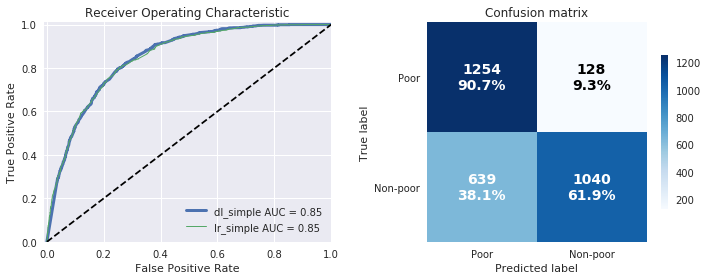

,dl_simple,lr_simple
accuracy,0.749428,0.766743
recall,0.907381,0.738784
precision,0.662441,0.743086
f1,0.765802,0.740929
cross_entropy,0.504059,0.478969
roc_auc,0.848825,0.847856
cohen_kappa,0.510115,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 72.36% 


In [9]:
# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Keras with all features <a class="anchor" id="all-feats"></a>

Now let's try using the full feature set

In [10]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

input_dim = X_train.shape[1]
hidden_layer_sizes = (700, 1024, 512, 256, 128, 64)
# Fit the model
model = KerasClassifier(build_fn=create_model, 
                        input_dim=input_dim, 
                        hidden_layer_sizes=hidden_layer_sizes,
                        keep_prob=0.7,
                        dropout_layers='all',
                        epochs=10, 
                        batch_size=10, 
                        verbose=1)

%time model.fit(X_train.as_matrix(), y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7_input (InputLayer)   (None, 484)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 700)               339500    
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              717824    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
__________

In [11]:
# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train, sample_weight=w_train) # must use args for Sequential.evaluate
print("In-sample score: {:0.2%}".format(score))

9183/9183 [==============================] - 4s 383us/step
CPU times: user 18.2 s, sys: 4.81 s, total: 23 s
Wall time: 3.55 s
In-sample score: 95.51%


12244/12244 [==============================] - 4s 325us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


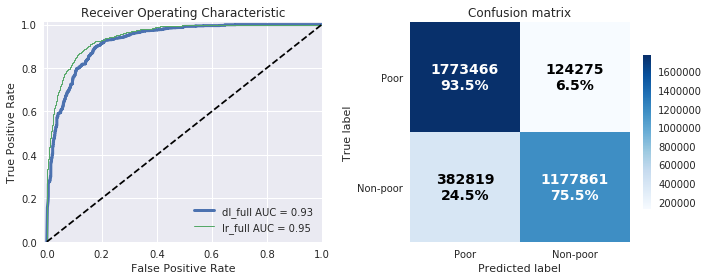

,dl_full,lr_full
accuracy,0.853374,0.873897
recall,0.934514,0.869754
precision,0.822464,0.853693
f1,0.874916,0.861649
cross_entropy,0.756312,0.288223
roc_auc,0.927875,0.948658
cohen_kappa,0.718693,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 59.23% 


In [12]:
# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

The default model gives us decent results on the full dataset, but the high in-sample score is a good indication of over-fitting.

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>



In [13]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

input_dim = X_train.shape[1]
# build the model
estimator = KerasClassifier(build_fn=create_model, 
                            input_dim=input_dim, 
                            dropout_layers='all',
                            epochs=10,
                            verbose=1)
parameters = {'hidden_layer_sizes': [(700, 1024, 512, 256, 128, 64)],
              'keep_prob': [0.5, 0.6, 0.7],
              'batch_size': [10, 64, 128, 256]
             }

model = GridSearchCV(estimator, parameters, verbose=3, cv=3)
%time model.fit(X_train.as_matrix(), y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] batch_size=10, hidden_layer_sizes=(700, 1024, 512, 256, 128, 64), keep_prob=0.5 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14_input (InputLayer)  (None, 484)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 700)               339500    
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              717824    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0     

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21_input (InputLayer)  (None, 484)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 700)               339500    
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              717824    
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
__________

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28_input (InputLayer)  (None, 484)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 700)               339500    
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              717824    
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
__________

In [14]:
# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

9183/9183 [==============================] - 2s 195us/step
CPU times: user 5.27 s, sys: 634 ms, total: 5.9 s
Wall time: 1.82 s
In-sample score: 96.45%
Best model parameters: {'batch_size': 256, 'hidden_layer_sizes': (700, 1024, 512, 256, 128, 64), 'keep_prob': 0.7}


12244/12244 [==============================] - 0s 41us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


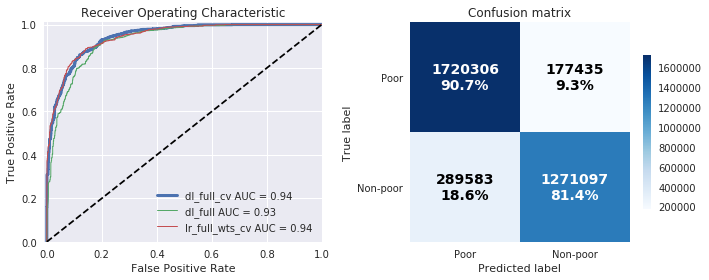

,dl_full_cv,dl_full,lr_full_wts_cv
accuracy,0.864962,0.853374,0.873458
recall,0.906502,0.934514,0.891581
precision,0.855921,0.822464,0.87947
f1,0.880486,0.874916,0.885484
cross_entropy,0.390082,0.756312,0.300498
roc_auc,0.944305,0.927875,0.944474
cohen_kappa,0.737508,0.718693,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 57.08% 


In [15]:
# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dl_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model.best_estimator_,
                                    features=X_test.columns.values)
best_model = model.best_estimator_

This gives us a noticeable boost in performance, with a better recall and much lower cross-entropy than the default model. 

In [16]:
model.best_params_

{'batch_size': 256,
 'hidden_layer_sizes': (700, 1024, 512, 256, 128, 64),
 'keep_prob': 0.7}

In [17]:
type(model.best_estimator_)
model.best_estimator_.model.save('../models/mwi/dl_full_cv.hd5')

# Deep Learning Classifier Malawi Summary <a class="anchor" id="summary"></a>



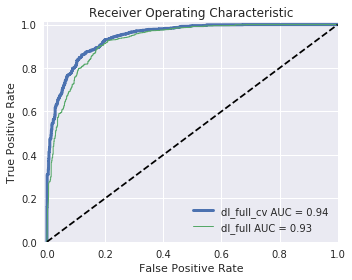

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
dl_full_cv,0.864962,0.906502,0.855921,0.880486,0.390082,0.944305,0.737508,0.0297718
dl_full,0.853374,0.934514,0.822464,0.874916,0.756312,0.927875,0.718693,0.0512043


In [18]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)